In [19]:
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Dataframe is being read <br/>
Padding is done here

In [20]:
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df

def dataframe(data):
    df=data['text']
    df0=df[range(0, len(df), 2)]
    df0=df0.iloc[1:]
    df0=df0.iloc[:-1]
    df0=df0.reset_index(drop=True)
    df1=df[range(1, len(df), 2)]
    df1=df1.iloc[1:]
    df1=df1.reset_index(drop=True)
    for i in range(len(df0)):
        df0[i] = ''.join(df0[i])

    for i in range(len(df1)):
        df1[i] = ''.join(df1[i])

    for i in range(len(df0)):
        df0[i]=df0[i].rjust(35, 'P')
        df0[i]=list(df0[i])
        df0[i].insert(0,'_BOM_')
        df0[i].append('_EOM_')

    for i in range(len(df1)):

        df1[i]=df1[i].rjust(35, 'P')
        df1[i]=list(df1[i])
        df1[i].insert(0,'_BOM_')
        df1[i].append('_EOM_')
    return df,df0,df1


drive.mount('/content/gdrive')
df_fer = read_file('gdrive/My Drive/golab/datasets/ferdousi.txt', 'ferdousi')
index=np.arange((len(df_fer)/2)-2)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


10% of the whole data is seprated for final test<br/> 
actually dataset is divided into 80% train, 10% validation and 10% test 

In [21]:
# 10 percent of data is separated for test dataset
testidx=np.random.choice(index,size=int(0.1*49600),replace=0)
trainidx=list(set(index)-set(testidx))

df: All Ferdousi poems<br/>
df0: dataset of first Mesra of all Beyts<br/>
df1: dataset of secound Mesra of all Beyts<br/>

In [22]:
df,df0,df1=dataframe(df_fer)

maximum length of all Mesras after padding is 37

In [23]:
maxlen=max(len(max(df0, key=len)),len(max(df1, key=len)))
maxlen


37

embedding word2vec

In [ ]:
word = pd.read_csv('farsi_literature_word2vec_model.txt', delimiter = "\n", )
df = pd.read_csv("farsi_literature_word2vec_model.txt")
words = []
embedding = []
for j in range(39778):
    a1 = list(df.iloc[j])
    c1 = 0
    for i in a1[0]:
        c1 += 1
        if i == ' ':
            break
    words.append(a1[0][0:c1-1])
    a2 = [float(x) for x in a1[0][c1:].split()]
    embedding.append(a2)

In [24]:


numm=''.join(np.ravel(df))
charSet=set(numm)
charSet=charSet.difference({'\n'})
padSet={'P','_BOM_','_EOM_'}
charSet=charSet.union(padSet)

df=np.asarray(df)
charList=list(charSet)
dicSize=len(charList)

charVec=np.eye((dicSize))


df0train=df0[trainidx]
df1train=df1[trainidx]
df0test=df0[testidx]
df1test=df1[testidx]

df0train=df0train.reset_index(drop=True)
df1train=df1train.reset_index(drop=True)
df0test=df0test.reset_index(drop=True)
df1test=df1test.reset_index(drop=True)

# Defining the inputs and outputs of network
x_train = np.zeros((len(df0train), maxlen, dicSize))
y_train = np.zeros((len(df1train), maxlen, dicSize))
y_train_shifted = np.zeros((len(df1train), maxlen, dicSize))

x_test = np.zeros((len(df0test), maxlen, dicSize))
y_test = np.zeros((len(df1test), maxlen, dicSize))
y_test_shifted = np.zeros((len(df1test), maxlen, dicSize))



In [25]:
df0train=df0train.reset_index(drop=True)
df0test

0       [_BOM_, P, P, P, P, P, P, P, P, P, ک, ه,  , ب,...
1       [_BOM_, P, P, P, P, P, P, P, P, P, چ, و,  , پ,...
2       [_BOM_, P, P, P, P, P, P, P, P, P, P, P, P, ب,...
3       [_BOM_, P, P, P, P, P, P, P, خ, ر, و, ش, ا, ن,...
4       [_BOM_, P, P, P, P, P, P, P, P, P, P, P, ب, ت,...
                              ...                        
4955    [_BOM_, P, P, P, P, P, P, P, P, P, P, P, پ, ش,...
4956    [_BOM_, P, P, P, P, P, P, P, P, P, ب, ه,  , ن,...
4957    [_BOM_, P, P, P, P, P, P, P, P, P, P, چ, و,  ,...
4958    [_BOM_, P, P, P, P, P, P, P, P, P, P, P, ن, م,...
4959    [_BOM_, P, P, P, P, P, P, P, P, P, P, P, و, ل,...
Name: text, Length: 4960, dtype: object

In [26]:
def one_hot_coder(mySeq, myDic):
    vector=np.zeros(shape=(len(mySeq),dicSize))
    for i in range(len(mySeq)):
      currentChar=mySeq[i]
      idx=myDic.index(currentChar)
      vector[i,:]=charVec[idx,:]
    return vector


for i in range(len(df0train)-1):
  x_train[i,:,:]=one_hot_coder(df0train[i],charList)
  y_train[i,:,:]=one_hot_coder(df1train[i],charList)
  a=one_hot_coder(df1train[i],charList)
  y_train_shifted[i,1:,:]=a[0:-1]


for i in range(len(df0test)-1):
  x_test[i,:,:]=one_hot_coder(df0test[i],charList)
  y_test[i,:,:]=one_hot_coder(df1test[i],charList)
  a=one_hot_coder(df1test[i],charList)
  y_test_shifted[i,1:,:]=a[0:-1]

### Encoder-Decoder using LSTM

Epoch 1/20
157/157 [==============================] - 8s 36ms/step - loss: 1.8538 - accuracy: 0.4852 - val_loss: 1.5653 - val_accuracy: 0.5487
Epoch 2/20
157/157 [==============================] - 4s 26ms/step - loss: 1.4770 - accuracy: 0.5754 - val_loss: 1.3979 - val_accuracy: 0.5958
Epoch 3/20
157/157 [==============================] - 4s 27ms/step - loss: 1.3433 - accuracy: 0.6129 - val_loss: 1.2874 - val_accuracy: 0.6282
Epoch 4/20
157/157 [==============================] - 5s 33ms/step - loss: 1.2337 - accuracy: 0.6442 - val_loss: 1.2016 - val_accuracy: 0.6524
Epoch 5/20
157/157 [==============================] - 4s 27ms/step - loss: 1.1575 - accuracy: 0.6650 - val_loss: 1.1400 - val_accuracy: 0.6697
Epoch 6/20
157/157 [==============================] - 4s 27ms/step - loss: 1.1010 - accuracy: 0.6804 - val_loss: 1.0999 - val_accuracy: 0.6800
Epoch 7/20
157/157 [==============================] - 5s 30ms/step - loss: 1.0604 - accuracy: 0.6911 - val_loss: 1.0686 - val_accuracy: 0.6895

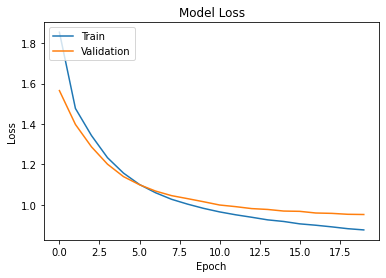

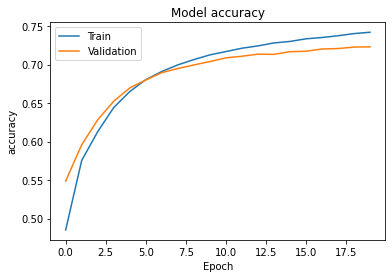

In [27]:

import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,RepeatVector,Input

x_train=x_train.astype(int)
y_train=y_train.astype(int)
y_train_shifted=y_train_shifted.astype(int)

# Hyperparameters
batch_size=256
num_lstm_outputs=256
epochs=20
lr=0.01


encoder_inputs = Input(shape=(None, dicSize),name='Encoder_Inputs')
decoder_inputs = Input(shape=(None, dicSize),name='Decoder_Inputs')


encoder_lstm = LSTM(num_lstm_outputs, return_state=True,name='LSTM_Encoder',activation='tanh',recurrent_activation='sigmoid')
_,hidden_state, cell_state = encoder_lstm(encoder_inputs)
decoder_initial_states = [hidden_state, cell_state]
decoder_lstm = LSTM(num_lstm_outputs, return_sequences=True, return_state=True,name='LSTM_Decoder',activation='tanh',recurrent_activation='sigmoid')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=decoder_initial_states)
decoder_dense = Dense(dicSize, activation='softmax',name='Dense_Layer')
decoder_outputs = decoder_dense(decoder_outputs)

# Training
opt=keras.optimizers.Adam(lr=lr)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')
history=model.fit([x_train, y_train_shifted], y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



# Model evaluation using testdataset

In [28]:

model.evaluate([x_test,y_test_shifted],y_test)


155/155 [==============================] - 1s 5ms/step - loss: 0.9241 - accuracy: 0.7307


[0.9240776896476746, 0.7307432293891907]

### Encoder-Decoder using GRU

Epoch 1/20
157/157 [==============================] - 8s 32ms/step - loss: 1.7348 - accuracy: 0.5166 - val_loss: 1.4585 - val_accuracy: 0.5796
Epoch 2/20
157/157 [==============================] - 4s 23ms/step - loss: 1.3189 - accuracy: 0.6206 - val_loss: 1.2200 - val_accuracy: 0.6466
Epoch 3/20
157/157 [==============================] - 4s 24ms/step - loss: 1.1531 - accuracy: 0.6658 - val_loss: 1.1540 - val_accuracy: 0.6654
Epoch 4/20
157/157 [==============================] - 4s 26ms/step - loss: 1.0728 - accuracy: 0.6869 - val_loss: 1.0736 - val_accuracy: 0.6873
Epoch 5/20
157/157 [==============================] - 4s 25ms/step - loss: 1.0248 - accuracy: 0.6994 - val_loss: 1.0567 - val_accuracy: 0.6918
Epoch 6/20
157/157 [==============================] - 4s 24ms/step - loss: 0.9938 - accuracy: 0.7080 - val_loss: 1.0272 - val_accuracy: 0.7006
Epoch 7/20
157/157 [==============================] - 4s 24ms/step - loss: 0.9701 - accuracy: 0.7142 - val_loss: 1.0143 - val_accuracy: 0.7040

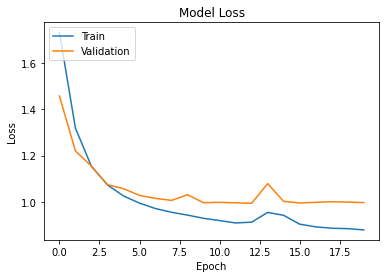

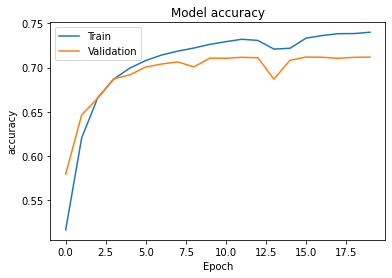

In [29]:

import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,RepeatVector,Input,GRU


# Hyperparameters
batch_size=256
num_lstm_outputs=256
epochs=20
lr=0.01

# Network Architecture
# Inputs of network
encoder_inputs = Input(shape=(None, dicSize),name='Encoder_Inputs')
decoder_inputs = Input(shape=(None, dicSize),name='Decoder_Inputs')

# Encoder LSTM
encoder = GRU(num_lstm_outputs, return_state=True)
_,hidden_state = encoder(encoder_inputs)
decoder_initial_states = [hidden_state]
decoder = GRU(num_lstm_outputs, return_sequences=True)
decoder_outputs = decoder(decoder_inputs,initial_state=decoder_initial_states)
decoder_dense = Dense(dicSize, activation='softmax',name='Dense_Layer')
decoder_outputs = decoder_dense(decoder_outputs)

# Training
opt=keras.optimizers.Adam(lr=lr)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=opt,metrics=['accuracy'], loss='categorical_crossentropy')
history=model.fit([x_train, y_train_shifted], y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




### Model evaluation using testdataset

In [30]:
model.evaluate([x_test,y_test_shifted],y_test)


155/155 [==============================] - 2s 5ms/step - loss: 0.9614 - accuracy: 0.7188


[0.9613818526268005, 0.718809962272644]